# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re 
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

# Loading Dataset

In [2]:
df = pd.read_json('Amazon reviews.json' , lines = True)

In [3]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [4]:
df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful','summary', 'unixReviewTime', 'reviewTime'],axis='columns',inplace=True)

In [5]:
df= df.rename(columns={"reviewText":"Review","overall": "Rating"})

In [6]:
df['review_len'] = [len(text.split()) for text in df.Review]

In [7]:
df = df[~(df['review_len'] < 20) & ~(df['review_len'] > 40)]

In [8]:
def convert_label(df) : 
    if df['Rating'] <= 3.0 : 
        rate = 0 # for Negative 
    else : 
        rate = 1 # for Positive
        
    return rate

In [9]:
df['Rating'] = df.apply(convert_label , axis = 1)

In [10]:
df.head()

,Review,Rating,review_len
0,They look good and stick good! I just don't li...,1,37
1,These stickers work like the review says they ...,1,32
2,These are awesome and make my phone look so st...,1,34
4,"awesome! stays on, and looks great. can be use...",1,23
5,These make using the home button easy. My daug...,0,23


# EDA

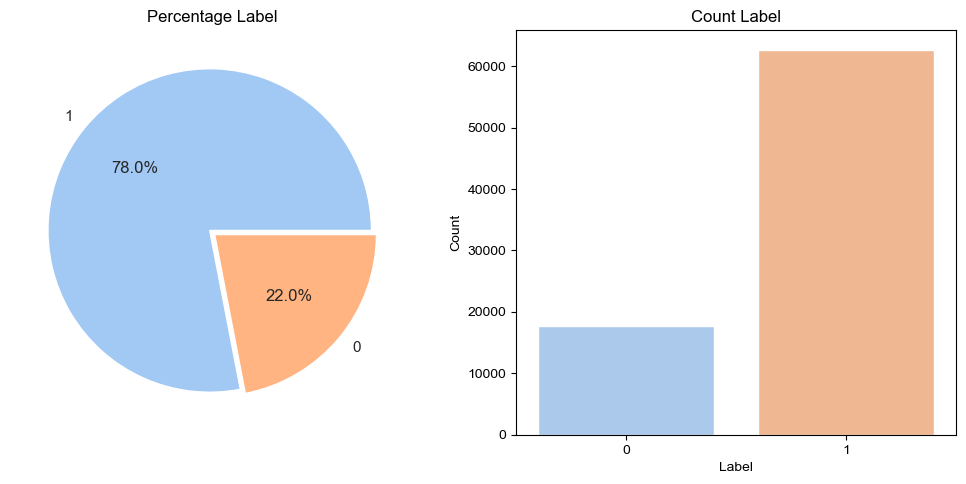

In [11]:
label_count = df['Rating'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

sns.countplot(df['Rating'] , ax=axes[1])
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
def MostWordsUsed(txt , n_words) : 
    all_text = ''.join(df[txt].values) 
    
    all_text = re.sub(r'\d+', '', all_text) # numbers
    all_text = re.sub(r'[^\w\s]', '', all_text) # special characters
    
    words = all_text.split() 
    
    # remove puncs
    punc = list(punctuation)
    words = [w for w in words if w not in punc] 
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if not word in stop_words]
    
    word_counts = Counter(words)
    
    top_words = word_counts.most_common(n_words)
    
    return top_words

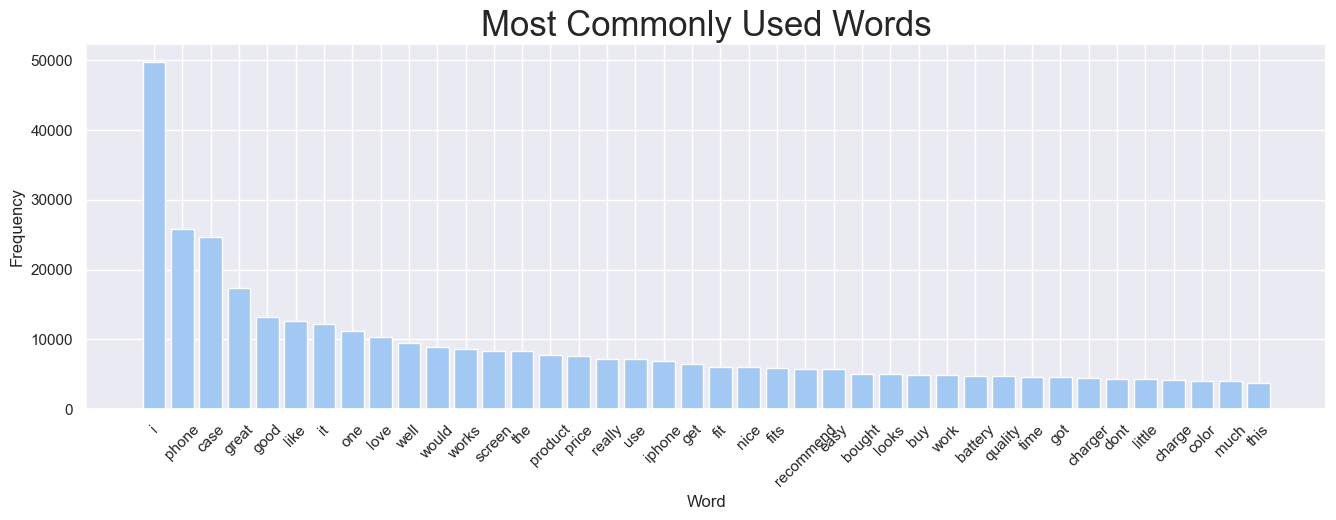

In [13]:
top_words = MostWordsUsed('Review' , 40)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()

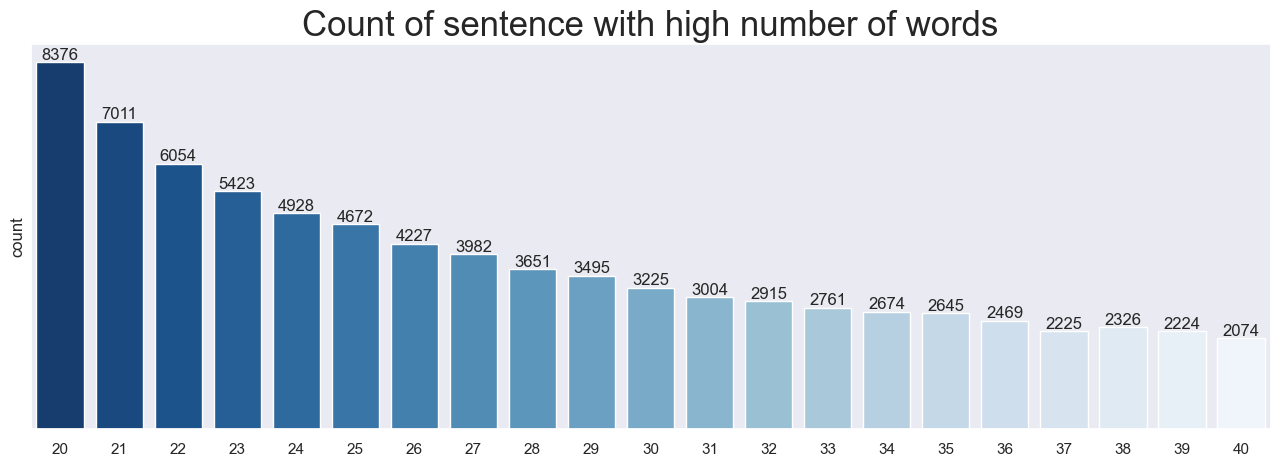

In [14]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='review_len', data=df[(df['review_len']<=1000) & (df['review_len']>10)], palette='Blues_r')
plt.title('Count of sentence with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Data Preprocessing

In [15]:
def DataPrep(text) : 
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if not word in stop_words]
    
    # lemmatization 
    words = [lemma.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

In [16]:
df['cleaned_reviews'] = df['Review'].apply(DataPrep)

In [17]:
print(f'There are around {int(df["cleaned_reviews"].duplicated().sum())} duplicated reviews, we will remove them.')

There are around 105 duplicated reviews, we will remove them.


In [18]:
df.drop_duplicates("cleaned_reviews", inplace=True)

# Split the data

In [19]:
x_train , x_val , y_train , y_val = train_test_split(df['cleaned_reviews'] , df['Rating'] , train_size = 0.80 , random_state = 42)

In [20]:
len(x_train) , len(x_val)

(64204, 16052)

# Feature Extraction

In [21]:
vec = TfidfVectorizer()
vec.fit(x_train)
print("No. of feature words: ",len(vec.get_feature_names()))

No. of feature words:  26813


In [22]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()

In [23]:
x_train.shape , x_val.shape

((64204, 26813), (16052, 26813))

# Logistic Regression

In [24]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train , y_train)

LogisticRegression(random_state=42)

In [25]:
train_acc1 = lr.score(x_train , y_train)

In [26]:
lr_pred = lr.predict(x_val)

val_acc1 = accuracy_score(y_val , lr_pred) 

val_precision1 = precision_score(y_val , lr_pred , average='weighted')
val_recall1 = recall_score(y_val , lr_pred , average='weighted')
val_f1score1 = f1_score(y_val , lr_pred , average='weighted')

In [27]:
print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1:0.2f}\n")

The training accuracy for logistic regression : 89.10%



The validation accuracy for logistic regression : 87.80%



The precision for logistic regression : 0.87



The recall for logistic regression : 0.88



The f1 score for logistic regression : 0.87




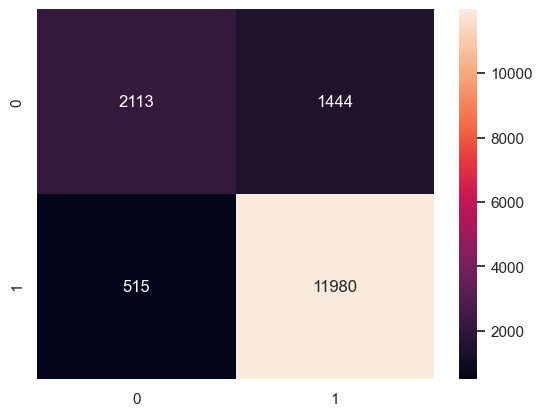

In [28]:
lr_cm = confusion_matrix(y_val , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

# Random Forest Classifier

In [29]:
rf = RandomForestClassifier()
rf.fit(x_train , y_train)

RandomForestClassifier()

In [30]:
train_acc2 = rf.score(x_train , y_train)

In [31]:
rf_pred = rf.predict(x_val)

val_acc2 = accuracy_score(y_val , lr_pred) 

val_precision2 = precision_score(y_val , rf_pred , average='weighted')
val_recall2 = recall_score(y_val , rf_pred , average='weighted')
val_f1score2 = f1_score(y_val , rf_pred , average='weighted')

In [32]:
print(f"The training accuracy for Random Forest : {(train_acc2*100):0.2f}%\n")
print(f"The validation accuracy for Random Forest : {(val_acc2*100):0.2f}%\n")
print(f"The precision for Random Forest : {val_precision2:0.2f}\n")
print(f"The recall for Random Forest : {val_recall2:0.2f}\n")
print(f"The f1 score for Random Forest : {val_f1score2:0.2f}\n")

The training accuracy for Random Forest : 100.00%



The validation accuracy for Random Forest : 87.80%



The precision for Random Forest : 0.85



The recall for Random Forest : 0.85



The f1 score for Random Forest : 0.82




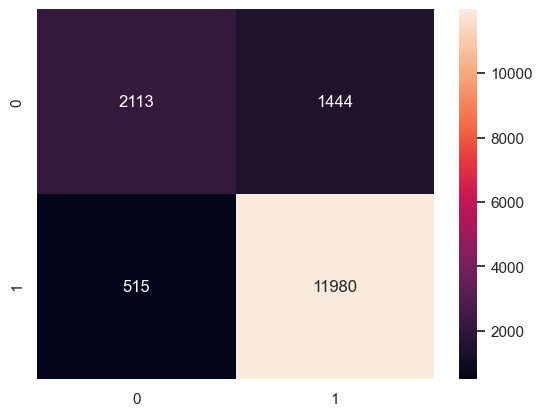

In [33]:
rf_cm = confusion_matrix(y_val , rf_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

# LSTM

In [34]:
X_train , X_val , Y_train , Y_val = train_test_split(df['cleaned_reviews'] , df['Rating'] , train_size = 0.80 , random_state = 42)

In [35]:
len(X_train) , len(X_val)

(64204, 16052)

In [36]:
corpus = [word for text in df['cleaned_reviews'] for word in text.split()]
words_count = Counter(corpus) 
sorted_words = words_count.most_common()

In [37]:
# define parameters 
VOCAB_SIZE = len(sorted_words) 
EMBEDDING_DIM = 300
MAX_LEN = np.max(df['review_len'])

In [38]:
def lstm_dataprep(row_data) : 
    tokenizer = Tokenizer(num_words=VOCAB_SIZE , oov_token='<OOV>')
    tokenizer.fit_on_texts(row_data)
    seqs = tokenizer.texts_to_sequences(row_data)
    pad_seqs = pad_sequences(seqs , maxlen = MAX_LEN , padding='post')
    
    return pad_seqs

In [39]:
X_train = lstm_dataprep(X_train)
X_val = lstm_dataprep(X_val)

In [40]:
X_train.shape , X_val.shape

((64204, 40), (16052, 40))

In [41]:
model = Sequential([
    Embedding(VOCAB_SIZE + 1 , EMBEDDING_DIM , input_length=MAX_LEN) , 
    Bidirectional(LSTM(265 , return_sequences=True)) , 
    Bidirectional(LSTM(128)) , 
    Dense(64 , activation='relu') , 
    Dense(1 , activation='sigmoid')
])

In [42]:
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, 40, 300)           9267300   

                                                                 

 bidirectional (Bidirectiona  (None, 40, 530)          1199920   

 l)                                                              

                                                                 

 bidirectional_1 (Bidirectio  (None, 256)              674816    

 nal)                                                            

                                                                 

 dense (Dense)               (None, 64)                16448     

                                                                 

 dense_1 (Dense)             (None, 1)                 65        

                                                                 


Total params: 11,158,549

Trainable par

In [43]:
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics=['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [44]:
history = model.fit(
    X_train , 
    Y_train , 
    epochs = 5 , 
    batch_size = 64 ,
    validation_data=(X_val , Y_val)
)

Epoch 1/5

1004/1004 [==============================] - 145s 142ms/step - loss: 0.3224 - accuracy: 0.8621 - precision: 0.8864 - recall: 0.9444 - val_loss: 0.6290 - val_accuracy: 0.7405 - val_precision: 0.7912 - val_recall: 0.9056

Epoch 2/5

1004/1004 [==============================] - 145s 145ms/step - loss: 0.2479 - accuracy: 0.8988 - precision: 0.9197 - recall: 0.9536 - val_loss: 0.7416 - val_accuracy: 0.7316 - val_precision: 0.7910 - val_recall: 0.8904

Epoch 3/5

1004/1004 [==============================] - 145s 144ms/step - loss: 0.2044 - accuracy: 0.9189 - precision: 0.9355 - recall: 0.9625 - val_loss: 0.8291 - val_accuracy: 0.7105 - val_precision: 0.7929 - val_recall: 0.8501

Epoch 4/5

1004/1004 [==============================] - 144s 143ms/step - loss: 0.1666 - accuracy: 0.9351 - precision: 0.9488 - recall: 0.9691 - val_loss: 0.8705 - val_accuracy: 0.7137 - val_precision: 0.7936 - val_recall: 0.8544

Epoch 5/5

1004/1004 [==============================] - 142s 142ms/step - lo

In [45]:
train_acc3 = history.history['accuracy'][-1] 
val_acc3 = history.history['val_accuracy'][-1]

In [46]:
print(f"The training loss for LSTM is : {history.history['loss'][-1]:0.2f}\n")
print(f"The training accuracy for LSTM is : {(history.history['accuracy'][-1]*100):0.2f}%\n")
print(f"The training precision for LSTM is : {history.history['precision'][-1]:0.2f}\n")
print(f"The training recall for LSTM is : {history.history['recall'][-1]:0.2f}\n")

The training loss for LSTM is : 0.13



The training accuracy for LSTM is : 94.98%



The training precision for LSTM is : 0.96



The training recall for LSTM is : 0.98




In [47]:
print(f"The validation loss for LSTM is : {history.history['val_loss'][-1]:0.2f}\n")
print(f"The validation accuracy for LSTM is : {(history.history['val_accuracy'][-1]*100):0.2f}%\n")
print(f"The validation precision for LSTM is : {history.history['val_precision'][-1]:0.2f}\n")
print(f"The validation recall of for LSTM is : {history.history['val_recall'][-1]:0.2f}\n")

The validation loss for LSTM is : 1.08



The validation accuracy for LSTM is : 71.39%



The validation precision for LSTM is : 0.79



The validation recall of for LSTM is : 0.86




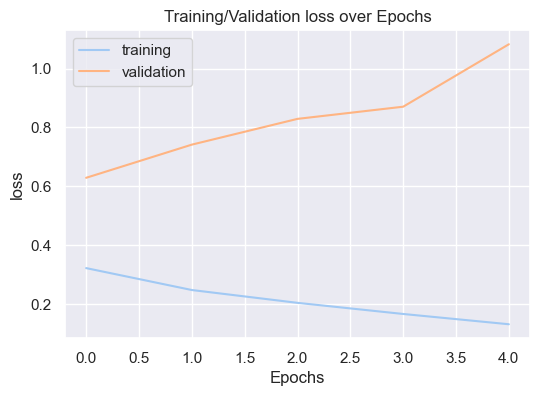

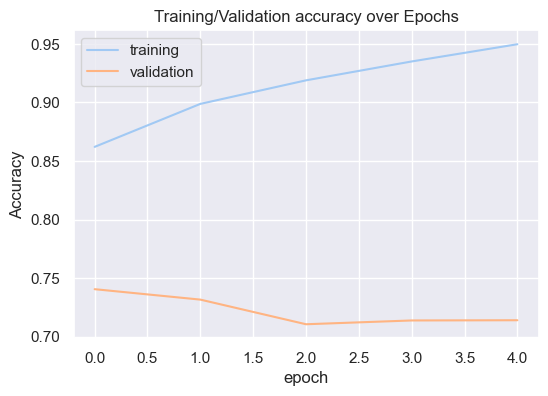

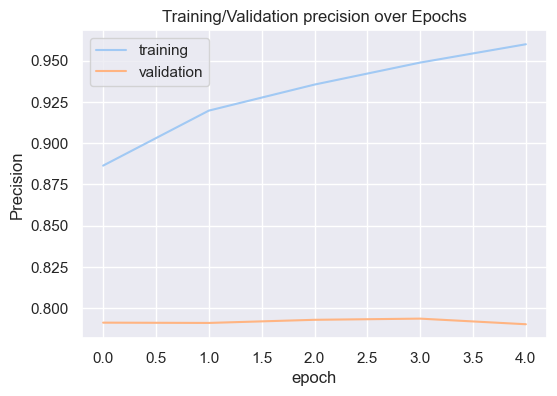

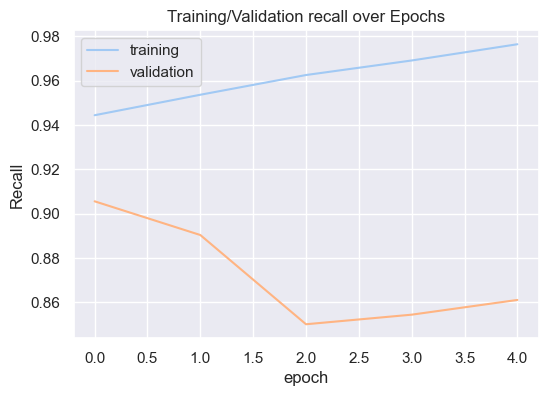

In [48]:
plt.subplots(figsize=(6,4))
plt.plot(history.history['loss'] , label='training')
plt.plot(history.history['val_loss'] , label='validation')

plt.title('Training/Validation loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.subplots(figsize=(6,4))
plt.plot(history.history['accuracy'], label='training')

plt.plot(history.history['val_accuracy'], label='validation')

plt.title('Training/Validation accuracy over Epochs')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplots(figsize=(6,4))
plt.plot(history.history['precision'], label='training')

plt.plot(history.history['val_precision'], label='validation')

plt.title('Training/Validation precision over Epochs')
plt.xlabel('epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.subplots(figsize=(6,4))
plt.plot(history.history['recall'], label='training')

plt.plot(history.history['val_recall'], label='validation')

plt.title('Training/Validation recall over Epochs')
plt.xlabel('epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [49]:
y_val_pred = model.predict(X_val)
y_val_pred = y_val_pred.round()

502/502 [==============================] - 10s 19ms/step


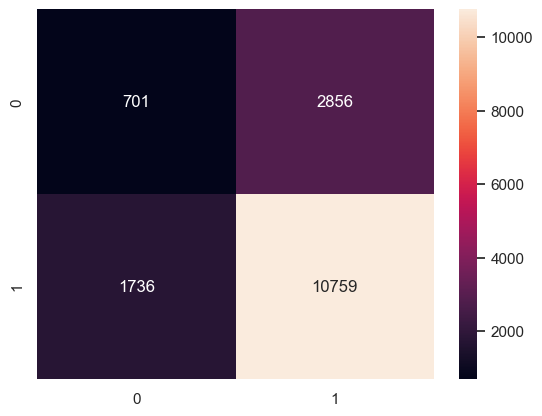

In [50]:
lstm_cm = confusion_matrix(Y_val , y_val_pred)
sns.heatmap(lstm_cm, annot=True,fmt='3g')
plt.show()

# Compare between models

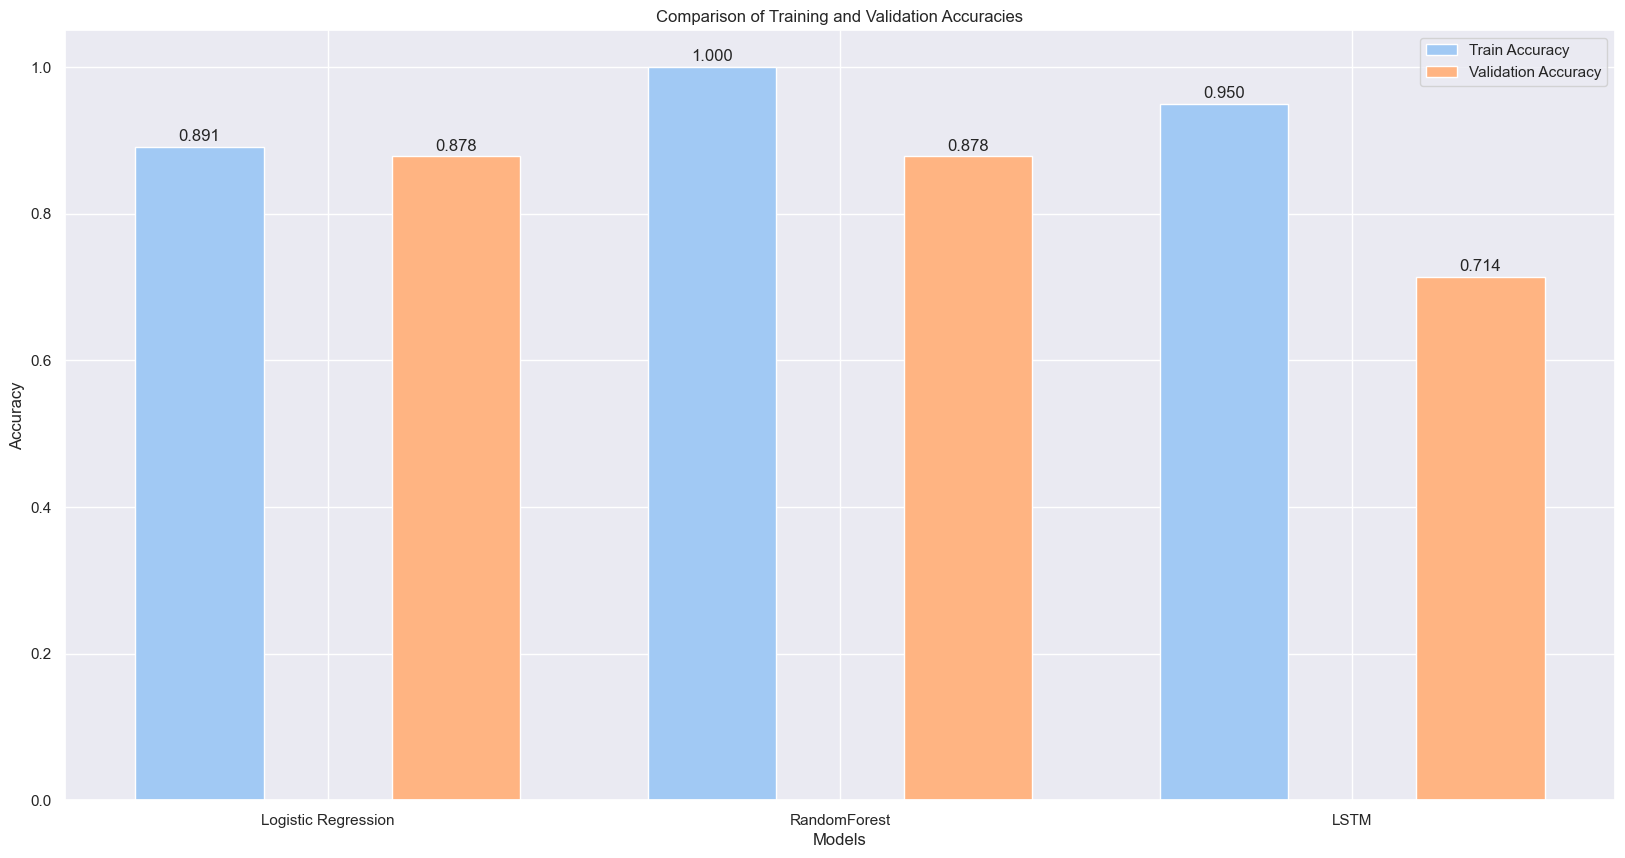

In [51]:
train_scores=[train_acc1,train_acc2,train_acc3]
val_scores=[val_acc1,val_acc2,val_acc3]

models = ['Logistic Regression','RandomForest','LSTM']

x = np.arange(len(models))

width = 0.25

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x - width, train_scores, width, label='Train Accuracy')

rects2 = ax.bar(x + width, val_scores, width, label='Validation Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Training and Validation Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()